## Creating CMIP climate anomalies

In [55]:
#Plotting and analysis libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
%matplotlib inline
import cartopy.feature as cf
import numpy as np
import xarray as xr
from scipy.stats import gaussian_kde
from tqdm.autonotebook import tqdm
import pandas as pd
import intake
import fsspec
import dask
import xmip.preprocessing as xmip
from dask_gateway import Gateway
from dask.distributed import Client
import cftime

import os
import sys
import glob
import importlib
plt.rcParams['figure.figsize'] = 12, 6

In [95]:
#Example helper function for pre processing, can also use xmip preprocessing functions

#%%
# def helper_func(ds):
#     """Rename `olevel` dim to `lev`"""
#     ds = ds.copy()
#     # a short example
#     ds = ds.squeeze()
#     if "dcpp_init_year" in ds.dims:
#         ds = ds.drop('dcpp_init_year')
#     return ds
# def helper_func(ds):
#     ds = ds.copy()
#     ds = ds.squeeze()
#     if ('longitude' in ds.dims) and ('latitude' in ds.dims):
#         ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
#     for coord in ds.coords:
#         if coord not in ['lat','lon','time']:
#             ds = ds.drop(coord)
#     return ds

In [56]:
# Define our machine's home directory
MACHDIR = os.path.expanduser("~")
HOMEREPO = '/dev/CMIP'
sys.path.append(MACHDIR + HOMEREPO + '/')

In [57]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [58]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


#### Catalogue DF lookup to see if required variables exist (not important)

In [99]:
# Get the catalog dataframe
df = col.df

# Define required variables
required_variables = {'tas', 'ps', 'mrso', 'huss'}

# Adjust table_id to include 'Amon' and 'Lmon' since 'mrso' is often under 'Lmon'
filtered_df = df[
    df['activity_id'].isin(['CMIP', 'ScenarioMIP']) &
    df['source_id'].isin(['NorESM2-MM', 'CESM2','HadGEM3-GC31-HM']) &
    df['experiment_id'].isin(['historical', 'ssp245', 'ssp585']) &
    df['variable_id'].isin(required_variables) &
    df['table_id'].isin(['Amon', 'Lmon'])   # Include 'Lmon' for 'mrso'
    #df['grid_label'] == 'gr'
]

# Group by unique combinations to ensure all variables are present
grouped = filtered_df.groupby(['source_id', 'experiment_id', 'member_id'])

valid_groups = []
for name, group in grouped:
    variables_in_group = set(group['variable_id'].unique())
    if required_variables.issubset(variables_in_group):
        valid_groups.append(group)
    else:
        print(f"Skipping group {name} because it lacks required variables.")

# Concatenate valid groups into a new dataframe
if valid_groups:
    valid_df = pd.concat(valid_groups)
else:
    raise ValueError("No datasets found with all required variables.")
valid_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
63808,CMIP,NCAR,CESM2,historical,r10i1p1f1,Lmon,mrso,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
64084,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
64108,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
64120,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,huss,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
197874,CMIP,NCAR,CESM2,historical,r11i1p1f1,Lmon,mrso,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190514
...,...,...,...,...,...,...,...,...,...,...,...
449606,ScenarioMIP,NCC,NorESM2-MM,ssp245,r2i1p1f1,Amon,huss,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20200702
376064,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,huss,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20191108
376124,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Lmon,mrso,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20191108
376183,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20191108


In [100]:
valid_df['source_id'].unique()

array(['CESM2', 'NorESM2-MM'], dtype=object)

### Catalogue Search

In [59]:
# Select the datasets for historical and future periods
query = {
    'activity_id': ['CMIP','ScenarioMIP'],
    'experiment_id': ['historical','ssp245', 'ssp585'],
    'source_id': ['E3SM-1-1','NorESM2-MM','CanESM5'],
    'variable_id': ['tas', 'ps', 'huss','areacello'],   #air temperature, surface pressure, specific humidity
    'table_id': ['Amon'],  # Monthly average data
    'member_id': ['r1i1p1f1']  # Only 1 realization for each dataset
}
cat_subset = col.search(**query)
cat_subset.df['source_id'].unique()
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
# Convert to xarray dataset
    dataset_dict = cat_subset.to_dataset_dict(
        zarr_kwargs={'consolidated': True, 'use_cftime':True},
        #preprocess=xmip.combined_preprocessing,
    )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [60]:
import xesmf as xe
ds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(0, 360, 1.0), {"units": "degrees_east"}),
    }
)

ds_target = ds_target.chunk({"lat": 25, "lon": 25})
ds_target = ds_target.unify_chunks()

for name,ds in tqdm(dataset_dict.items()):
    # define the regridder object (from our source dataarray to the target)
    regridder = xe.Regridder(
        ds, ds_target, "bilinear", periodic=True)
    # apply the regridder to our source dataarray
    dataset_dict[name] = regridder(ds, keep_attrs=True).compute()

  0%|          | 0/9 [00:00<?, ?it/s]

In [225]:
varload = 'tas'
latbound = [25.375, 49.375] #
lonbound = [-124.625, -67.125] #

In [61]:
#Preprocess(?) here
for name,ds in dataset_dict.items():
    ds = xr.decode_cf(ds)
    #ds = xmip.replace_x_y_nominal_lat_lon(ds)
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
         ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
    for coord in ds.coords:
     if coord not in ['lat','lon','time']:
          ds = ds.drop(coord)  
     dataset_dict[name] = ds

In [ ]:
# Fake Amazon lat = 32 , lon = 271
# Amazon lat = 4.2/25.62  , lon = 300.1/279.1
# SB lat = 34.5, lon = 240
# Harvard lat = 42.5, lon = 287.8

In [ ]:
# Fake Amazon lat = 32 , lon = -89
# Amazon lat = 4.2/25.62 , lon = 300.1/-80.75
# SB lat = 34.5, lon = -120
# Harvard lat = 42.5, lon = -72.2

In [62]:
latitude = 32
longitude = 271

In [63]:
dict_tas = {}
for name, ds in tqdm(dataset_dict.items()):
    scenario = ds.attrs['experiment_id']
    model = ds.attrs['source_id']
    varname = 'tas'
    year_begin = ds['time'].values[0].year
    year_end = ds['time'].values[-1].year
    ds = ds.sel(time=slice('1850', '2100'))
    ds = ds.sel(lat=latitude, lon=longitude, method='nearest')
    tas_pick = ds[varname].values
    tas_pick_mean = tas_pick.mean()
    dict_tas['{}{}_mean_tas_{}_{}'.format(model,scenario,year_begin,year_end)] = tas_pick_mean

dict_tas

  0%|          | 0/9 [00:00<?, ?it/s]

{'CanESM5historical_mean_tas_1850_2014': 291.76105,
 'CanESM5ssp245_mean_tas_2015_2100': 294.78186,
 'NorESM2-MMssp585_mean_tas_2015_2100': 296.07306,
 'CanESM5ssp585_mean_tas_2015_2300': 295.9815,
 'NorESM2-MMhistorical_mean_tas_1850_2014': 293.13403,
 'E3SM-1-1ssp245_mean_tas_2020_2024': 291.56796,
 'NorESM2-MMssp245_mean_tas_2015_2100': 295.3238,
 'E3SM-1-1historical_mean_tas_1850_2014': 290.2617,
 'E3SM-1-1ssp585_mean_tas_2015_2100': 295.29358}

In [64]:
gmst_dict = {}
for name, ds in tqdm(dataset_dict.items()):
    ds = ds.sel(lat=latitude, lon=longitude, method='nearest')
    gmst = (ds['tas'])
    gmst_dict[name] = gmst.squeeze()

  0%|          | 0/9 [00:00<?, ?it/s]

In [65]:
#Splicing and joining the datasets
gmst_ssp_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    if 'ssp' not in name: continue # keep only SSP simulations
            
    add_hist_gmst = None
    
    # Loop through dictionary to find matching historical simulation
    for hist_name, hist_gmst in gmst_dict.items():
        model_name = name.split(".")[2] # extract model name from name of simulation
        
        # find historical simulation that matches SSP simulation (same model)
        if (model_name in hist_name) and ('historical' in hist_name):
            add_hist_gmst = hist_gmst
    
    # if we found one, slice it together with the SSP and add it to the dictionary
    if add_hist_gmst is not None:
        gmst_ssp = xr.concat([add_hist_gmst, gmst],dim='time')
        gmst_ssp_dict[name] = gmst_ssp

In [66]:
#Creating Average annual anomalies
gmst_ann = {}
for name, gmst in tqdm(gmst_ssp_dict.items()): # loop through each model
    
    # remove the climatological seasonal cycle from the signal, for visual clarity
    gmst['time'] = gmst['time'].astype('datetime64[ns]')
    gmst_climatology = gmst.groupby(gmst['time'].dt.month).mean('time')
    gmst_anomalies = gmst.groupby(gmst['time'].dt.month) - gmst_climatology
    
    # reference the GMST relative to the 1990 to 2010 pre-industrial period
    gmst_anomalies = gmst_anomalies - gmst_anomalies.isel(time=slice(1990,2010)).mean(dim='time')
    
    # calculate annual-averages, to smooth the time-series a bit
    gmst_ann_anomalies = gmst_anomalies.groupby(gmst_anomalies['time'].dt.year).mean('time')
    gmst_ann_anomalies = gmst_ann_anomalies.rename(
        r'mean surface temperature ($^{\circ}$C) (relative to 1990-2010)'
    )
    
    gmst_ann[name] = gmst_ann_anomalies.compute() 

  0%|          | 0/6 [00:00<?, ?it/s]

In [67]:
gmst_monthly = {}
for name, gmst in tqdm(gmst_ssp_dict.items()): # loop through each model
    
    # remove the climatological seasonal cycle from the signal, for visual clarity
    gmst['time'] = gmst['time'].astype('datetime64[ns]')
    gmst_climatology = gmst.groupby(gmst['time'].dt.month).mean('time')
    gmst_anomalies = gmst.groupby(gmst['time'].dt.month) - gmst_climatology
    
    # reference the GMST relative to the 1850 to 1900 pre-industrial period
    gmst_anomalies_monthly = gmst_anomalies - gmst_anomalies.isel(time=slice(1990,2010)).mean(dim='time')
    
    gmst_monthly[name] = gmst_anomalies_monthly.compute() 

  0%|          | 0/6 [00:00<?, ?it/s]

In [68]:
gmst_ssp_dict= {key.split('.')[2] + '.' + key.split('.')[3]: ds for key, ds in gmst_ssp_dict.items()}
gmst_monthly = {key.split('.')[2] + '.' + key.split('.')[3]: ds for key, ds in gmst_monthly.items()}
gmst_ann = {key.split('.')[2] + '.' + key.split('.')[3]: ds for key, ds in gmst_ann.items()}

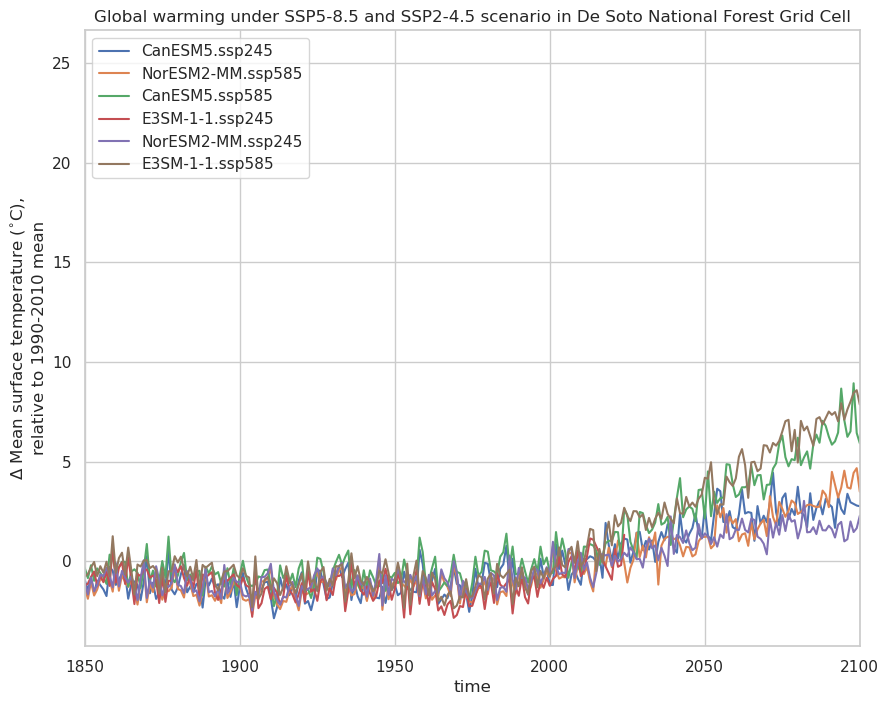

In [69]:
plt.figure(figsize=(10,8))

for name, gmst_ssp in gmst_ann.items():
    #gmst_ssp = gmst_ssp.groupby(gmst_ssp['time'].dt.year).mean('year')
    gmst_ssp.plot()
    
plt.xlabel('time')
plt.ylabel(r'${\Delta}$ Mean surface temperature ($^{\circ}$C),'
           '\n'
           'relative to 1990-2010 mean')
plt.title('Global warming under SSP5-8.5 and SSP2-4.5 scenario in De Soto National Forest Grid Cell')
plt.grid(True)
plt.legend(gmst_ssp_dict.keys(), loc='upper left')
plt.xlim([1850,2100]);
#plt.savefig('../figures/ssp585_global_warming.png',dpi=100,bbox_inches='tight')
plt.show()

In [70]:
list(gmst_monthly.keys())

['CanESM5.ssp245',
 'NorESM2-MM.ssp585',
 'CanESM5.ssp585',
 'E3SM-1-1.ssp245',
 'NorESM2-MM.ssp245',
 'E3SM-1-1.ssp585']

In [71]:
anomaly_dict = {}

for key, gmst_ssp in gmst_monthly.items():
    df = gmst_ssp.to_dataframe()
    df.rename(columns={df.columns[3]: 'tas_anomaly'}, inplace=True)
    df.drop(columns=['lat','lon','month'], inplace=True)
    anomaly_dict[key] = df

In [72]:
anomaly_dict['CanESM5.ssp245']

,tas_anomaly
time,
1850-01-16 12:00:00,-0.453926
1850-02-15 00:00:00,-1.794014
1850-03-16 12:00:00,0.312798
1850-04-16 00:00:00,1.495537
1850-05-16 12:00:00,-2.082527
...,...
2100-08-16 12:00:00,1.483360
2100-09-16 00:00:00,3.157005
2100-10-16 12:00:00,3.588097


In [73]:
desoto_combined_df = pd.DataFrame()

# Loop through the dictionary to build the combined DataFrame
for key, df in anomaly_dict.items():
    # Extract model and scenario from the key
    model, scenario = key.split('.')
    # Add a column for the model and scenario
    df['model'] = model
    df['scenario'] = scenario
    df.reset_index(inplace=True)  # Ensure time is a column if not already
    desoto_combined_df = pd.concat([desoto_combined_df, df], ignore_index=True)
    desoto_combined_df['time'] = pd.to_datetime(desoto_combined_df['time'])
    desoto_combined_df['year'] = desoto_combined_df['time'].dt.year
    desoto_combined_df['month'] = desoto_combined_df['time'].dt.month


print(desoto_combined_df)

                     time  tas_anomaly     model scenario  year  month
0     1850-01-16 12:00:00    -0.453926   CanESM5   ssp245  1850      1
1     1850-02-15 00:00:00    -1.794014   CanESM5   ssp245  1850      2
2     1850-03-16 12:00:00     0.312798   CanESM5   ssp245  1850      3
3     1850-04-16 00:00:00     1.495537   CanESM5   ssp245  1850      4
4     1850-05-16 12:00:00    -2.082527   CanESM5   ssp245  1850      5
...                   ...          ...       ...      ...   ...    ...
19495 2100-08-16 12:00:00     8.169113  E3SM-1-1   ssp585  2100      8
19496 2100-09-16 00:00:00     8.241745  E3SM-1-1   ssp585  2100      9
19497 2100-10-16 12:00:00     8.746201  E3SM-1-1   ssp585  2100     10
19498 2100-11-16 00:00:00     6.638931  E3SM-1-1   ssp585  2100     11
19499 2100-12-16 12:00:00     6.995590  E3SM-1-1   ssp585  2100     12

[19500 rows x 6 columns]


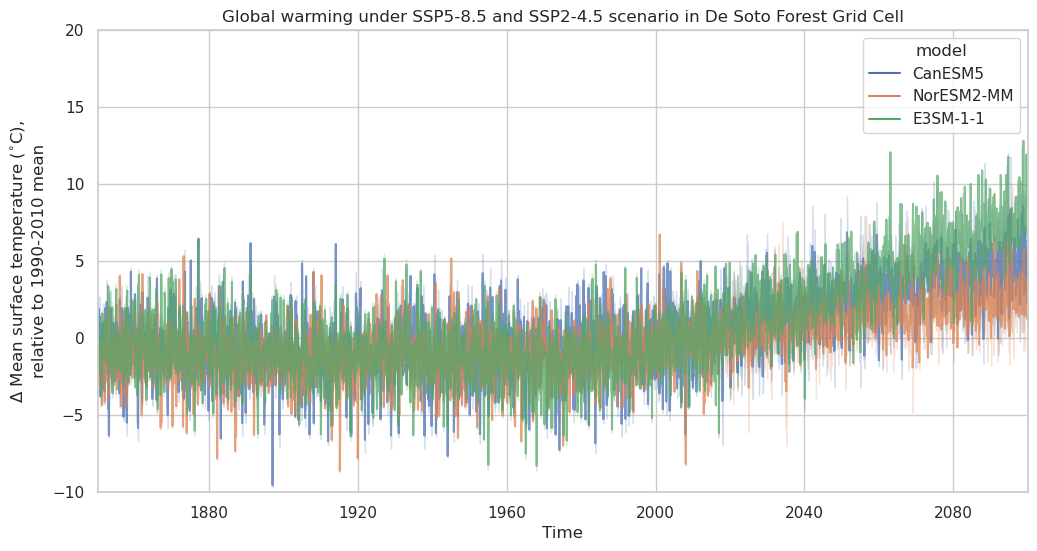

In [75]:
sns.set_theme(style="whitegrid")
p=sns.lineplot(data=desoto_combined_df, x='time', y='tas_anomaly',hue='model',alpha=0.7)

p.axis(xmin=cftime.DatetimeNoLeap(1850, 1, 1), xmax=cftime.DatetimeNoLeap(2100, 1, 1))
p.axis(ymin=-10, ymax=20)
plt.xlabel('Time')
plt.ylabel(r'${\Delta}$ Mean surface temperature ($^{\circ}$C),'
           '\n'
           'relative to 1990-2010 mean')
plt.title('Global warming under SSP5-8.5 and SSP2-4.5 scenario in De Soto Forest Grid Cell')
plt.show()

In [76]:
desoto_combined_df.drop(columns=['time'], inplace=True)

In [77]:
desoto_combined_df

,tas_anomaly,model,scenario,year,month
0,-0.453926,CanESM5,ssp245,1850,1
1,-1.794014,CanESM5,ssp245,1850,2
2,0.312798,CanESM5,ssp245,1850,3
3,1.495537,CanESM5,ssp245,1850,4
4,-2.082527,CanESM5,ssp245,1850,5
...,...,...,...,...,...
19495,8.169113,E3SM-1-1,ssp585,2100,8
19496,8.241745,E3SM-1-1,ssp585,2100,9
19497,8.746201,E3SM-1-1,ssp585,2100,10
19498,6.638931,E3SM-1-1,ssp585,2100,11


In [78]:
desoto_combined_df.to_csv('desoto_anomaly_df.csv', index=False)

## Make Met DFs and VPD

In [79]:
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units

In [80]:
test_gldas = xr.open_mfdataset('/home/mdshadman_amin/data/GLDAS_Processed_NorthAmerica/GLDAS_CLSM025_D_A20000101_*.nc',combine='by_coords')

In [ ]:
# # Fake Amazon lat = 32 , lon = -89
# Amazon lat = 4.2/25.62 , lon = -60.1/-80.75
# SB lat = 34.5, lon = -120
# Harvard lat = 42.5, lon = -72.2

In [81]:
test_gldas

<xarray.Dataset>
Dimensions:                (time: 5478, lon: 377, lat: 188)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01 ... 2014-12-30
  * lon                    (lon) float32 -144.1 -143.9 -143.6 ... -50.38 -50.12
  * lat                    (lat) float64 24.12 24.38 24.62 ... 70.38 70.62 70.88
Data variables:
    PAR_tavg               (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>
    Qair_f_tavg            (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>
    SoilPotential_RZ_tavg  (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>
    Tair_f_tavg            (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>
    VPD_f_tavg             (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>

In [82]:
loc_dict = {'desoto': {'lat': 32, 'lon': -89.5},
            'amazon': {'lat': 25.62, 'lon': -80.75},
            'sb': {'lat': 34.625, 'lon': -120},
            'harvard': {'lat': 42.5, 'lon': -72.2}}

In [ ]:
pressure = 1013.25 * units.hPa
rh_dict = {}
for loc, loc_info in loc_dict.items():
    qair = test_gldas['Qair_f_tavg'].sel(lat=loc_info['lat'], lon=loc_info['lon'], method='nearest')
    temp = test_gldas['Tair_f_tavg'].sel(lat=loc_info['lat'], lon=loc_info['lon'], method='nearest')
    rh = mpcalc.relative_humidity_from_specific_humidity(pressure, temp * units.degC, qair * (units.kg / units.kg))
    rh_dict[loc] = rh

df_dict = {}

for loc, rh in rh_dict.items():
    df_dict[loc] = rh.to_dataframe()
    df_dict[loc] = df_dict[loc].drop(columns=['lat','lon'])
    df_dict[loc] = df_dict[loc].reset_index()
    df_dict[loc] = df_dict[loc].rename(columns={df_dict[loc].columns[1]: f'{loc}_rh'})

rh_df = next(iter(df_dict.values()))
for loc, df in df_dict.items():
    if loc != list(df_dict.keys())[0]:
        rh_df = pd.merge(rh_df, df, on='time', how='outer')

rh_df = rh_df.resample('M', on='time').mean()
rh_df.reset_index(inplace=True)
rh_df['time'] = rh_df['time'].dt.strftime('%Y-%m')
#rh_df.to_csv('/home/mdshadman_amin/dev/CMIP/mets/rh_df.csv', index=False)

In [94]:
desoto_met = test_gldas.sel(lat=32, lon=-89.5, method='nearest')

In [95]:
max(desoto_met['Tair_f_tavg'].values)

32.538544

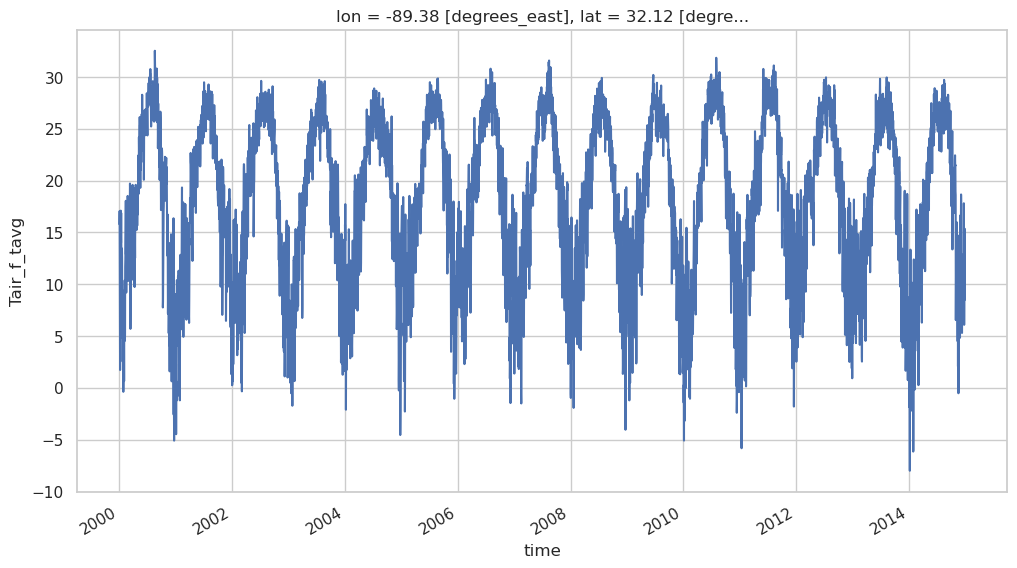

In [96]:
desoto_met['Tair_f_tavg'].plot()

In [97]:
desoto_met_df = desoto_met.to_dataframe()

In [98]:
desoto_met_df

,lon,lat,PAR_tavg,Qair_f_tavg,SoilPotential_RZ_tavg,Tair_f_tavg,VPD_f_tavg
time,,,,,,,
2000-01-01,-89.375,32.125,195.782501,0.010282,-0.046329,15.796936,1.423552
2000-01-02,-89.375,32.125,177.381973,0.010996,-0.046930,17.067413,1.787451
2000-01-03,-89.375,32.125,176.927246,0.007912,-0.047847,12.001923,1.310853
2000-01-04,-89.375,32.125,180.232925,0.007233,-0.048069,10.182190,0.805188
2000-01-05,-89.375,32.125,205.509338,0.003228,-0.046674,1.726898,1.732990
...,...,...,...,...,...,...,...
2014-12-26,-89.375,32.125,145.254837,0.006964,-0.033595,9.933105,1.032664
2014-12-27,-89.375,32.125,105.802773,0.009988,-0.031802,14.203583,0.145086
2014-12-28,-89.375,32.125,119.483688,0.010730,-0.026931,15.366425,0.214586


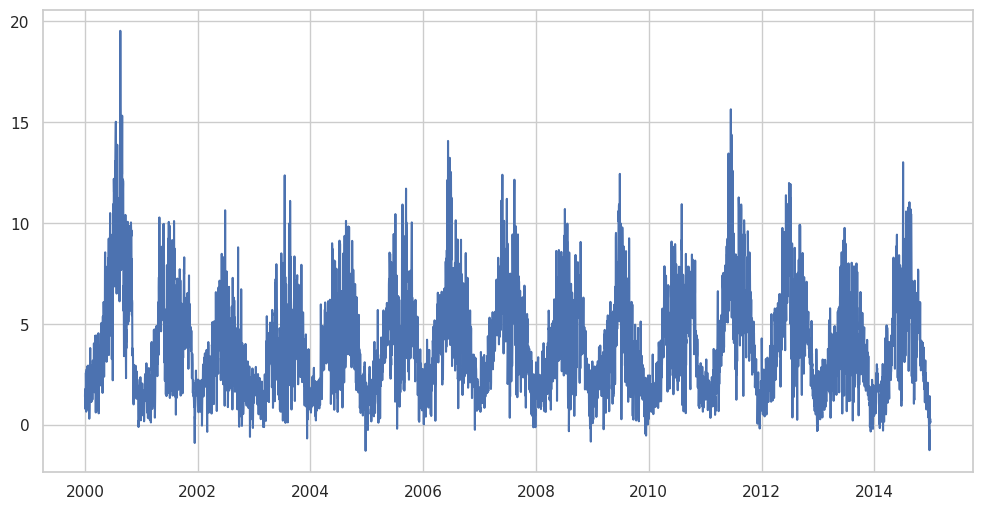

In [99]:
plt.plot(desoto_met_df['VPD_f_tavg'])

In [100]:
def prep_metcsv_hotter(df):
    df = df.drop(columns=['lat','lon','PAR_tavg','Qair_f_tavg'])
    df = df.rename(columns={'Tair_f_tavg':'tair','SoilPotential_RZ_tavg':'psis','VPD_f_tavg':'D'})
    df['Ca'] = 420
    df['al'] = 10
    df = df.reset_index()
    return df

In [101]:
desoto_met_df=prep_metcsv_hotter(desoto_met_df)

In [102]:
desoto_met_df

,time,psis,tair,D,Ca,al
0,2000-01-01,-0.046329,15.796936,1.423552,420,10
1,2000-01-02,-0.046930,17.067413,1.787451,420,10
2,2000-01-03,-0.047847,12.001923,1.310853,420,10
3,2000-01-04,-0.048069,10.182190,0.805188,420,10
4,2000-01-05,-0.046674,1.726898,1.732990,420,10
...,...,...,...,...,...,...
5473,2014-12-26,-0.033595,9.933105,1.032664,420,10
5474,2014-12-27,-0.031802,14.203583,0.145086,420,10
5475,2014-12-28,-0.026931,15.366425,0.214586,420,10
5476,2014-12-29,-0.025615,12.316101,0.127021,420,10


In [ ]:
#desoto_met_df.to_csv('/home/mdshadman_amin/dev/CMIP/mets/hotter_base_desoto_met_df.csv', index=False)

In [104]:
rh_df

,time,desoto_rh,amazon_rh,sb_rh,harvard_rh
0,2000-01,0.851499,0.738738,0.850474,0.738078
1,2000-02,0.831736,0.733081,0.888835,0.799588
2,2000-03,0.856160,0.741111,0.806068,0.830757
3,2000-04,0.812973,0.719161,0.770499,0.849653
4,2000-05,0.802607,0.717614,0.727818,0.884690
...,...,...,...,...,...
175,2014-08,0.795755,0.789010,0.725994,0.804544
176,2014-09,0.881142,0.829346,0.723260,0.794121
177,2014-10,0.779386,0.774991,0.672454,0.855137
178,2014-11,0.758917,0.782128,0.693054,0.755095


In [70]:
rh_df = pd.read_csv('/home/mdshadman_amin/dev/CMIP/mets/rh_df.csv')

In [105]:
base_met_df = pd.read_csv('/home/mdshadman_amin/dev/CMIP/mets/hotter_base_desoto_met_df.csv')
base_met_df['D'] = base_met_df['D'] * 100
base_met_df['time'] = pd.to_datetime(base_met_df['time'])
base_met_df = base_met_df.resample('M', on='time').mean()
base_met_df = base_met_df.reset_index()
base_met_df['time'] = base_met_df['time'].dt.strftime('%Y-%m')
anomaly_df = pd.read_csv('/home/mdshadman_amin/dev/CMIP/mets/desoto_anomaly_df.csv')
anomaly_df['time'] = anomaly_df['time'] = pd.to_datetime(anomaly_df[['year', 'month']].assign(day=1),errors='coerce')
anomaly_df = anomaly_df.drop(columns=['year','month'])
anomaly_df['time'] = anomaly_df['time'].dt.strftime('%Y-%m')
anomaly_df = anomaly_df[(anomaly_df['time'] > '2085-12-30') & (anomaly_df['time'] <= '2100-12-30')]
merged_df = pd.merge(base_met_df, anomaly_df, on='time', how='outer')


In [106]:
model_list = ['CanESM5', 'E3SM-1-1', 'NorESM2-MM']
scenario_list = ['ssp245', 'ssp585']

df = anomaly_df

# Extract the relevant series from base_met_df
tair_series = base_met_df['tair'].to_list()
psis_series = base_met_df['psis']
ca_series = base_met_df['Ca']
al_series = base_met_df['al']
time_series = base_met_df['time']

In [107]:
specific_data = {}

for model in model_list:
    for scenario in scenario_list:
        filtered_data = df[(df['model'] == model) & (df['scenario'] == scenario)].copy()
        filtered_data.reset_index(drop=True, inplace=True)
        new_df = pd.DataFrame()
        new_df['model'] = filtered_data['model']
        new_df['scenario'] = filtered_data['scenario']
        new_df['time'] = time_series.values
        future_tair = []
        for i in range(len(filtered_data)):
            future_tair.append(tair_series[i] + filtered_data.iloc[i]['tas_anomaly'])
        new_df['future_tair'] = pd.Series(future_tair)
        new_df['psis'] = psis_series.values
        new_df['Ca'] = ca_series.values
        new_df['al'] = al_series.values

        # Store the new dataframe in the dictionary with a key as (model, scenario)
        specific_data[(model, scenario)] = new_df


In [108]:
def met_to_vpd(air_temp, rh):
    es = (611.2 * np.exp((17.27 * air_temp) / (air_temp + 237.3)))
    vpd = (1 - (rh)) * es
    return vpd

In [109]:
location = 'desoto'
# Select the appropriate RH column based on the location
rh_column = f"{location}_rh"
if rh_column in rh_df.columns:
    for (model, scenario), data in specific_data.items():
        rh_merger = pd.merge(data, rh_df[['time', rh_column]], on='time', how='left')
        rh_merger['D'] = met_to_vpd(rh_merger['future_tair'], rh_merger[rh_column])
        specific_data[(model, scenario)]['D'] = rh_merger['D']
else:
    print(f"Warning: RH data for {location} not found in rh_dataframe")

In [110]:
# Example of how to access data for a specific model-scenario combination
model_name = 'CanESM5'
scenario_name = 'ssp245'
example_data = specific_data.get((model_name, scenario_name), None)

# Print the modified data for example access
print(example_data)

       model scenario     time  future_tair      psis     Ca    al           D
0    CanESM5   ssp245  2000-01     9.087613 -0.037650  420.0  10.0  171.611851
1    CanESM5   ssp245  2000-02    15.024555 -0.037115  420.0  10.0  287.590380
2    CanESM5   ssp245  2000-03    17.511717 -0.036791  420.0  10.0  288.078575
3    CanESM5   ssp245  2000-04    18.690862 -0.026896  420.0  10.0  403.376046
4    CanESM5   ssp245  2000-05    26.560131 -0.053205  420.0  10.0  686.264671
..       ...      ...      ...          ...       ...    ...   ...         ...
175  CanESM5   ssp245  2014-08    28.680903 -0.051034  420.0  10.0  803.697483
176  CanESM5   ssp245  2014-09    28.584686 -0.050974  420.0  10.0  465.101668
177  CanESM5   ssp245  2014-10    23.162251 -0.077081  420.0  10.0  626.320682
178  CanESM5   ssp245  2014-11    14.853218 -0.045326  420.0  10.0  407.528151
179  CanESM5   ssp245  2014-12    15.304250 -0.041638  420.0  10.0  119.788571

[180 rows x 8 columns]


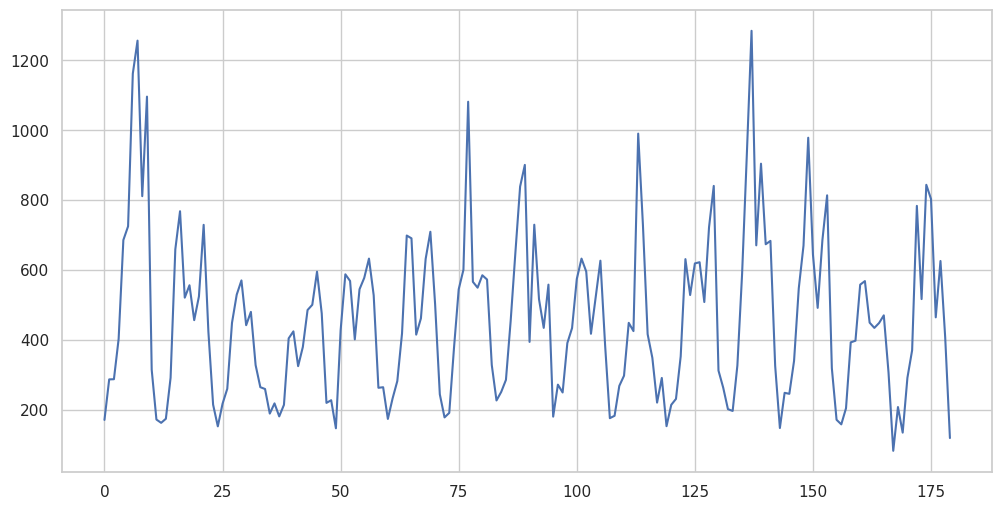

In [111]:
plt.plot(example_data['D'])

In [112]:
for (model, scenario), data in specific_data.items():
    data.to_csv(f'/home/mdshadman_amin/dev/CMIP/mets/hotter_load/hotter_{model}_{scenario}_{location}_met.csv', index=False)

## Visualization

In [117]:
loader_directory = '/home/mdshadman_amin/dev/CMIP/mets/hotter_load/'

def load_and_combine_csvs(directory):
    # Create an empty list to store dataframes
    dfs = []

    # Loop through the directory and load all CSVs
    for filename in os.listdir(directory):
        if filename.endswith('.csv') and filename.startswith('hotter_'):
            # Extract the model, scenario, and location from the filename
            parts = filename.split('_')
            model = parts[1]
            scenario = parts[2]
            location = parts[3]

            # Load the CSV file
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            # Check if the filename contains 'ssp245' or 'ssp585' and drop columns
            if 'ssp245' in filename or 'ssp585' in filename:
                df = df.drop(columns=['model', 'scenario'])

            # Rename 'tair' to 'future_tair' if 'tair' exists in columns
            if 'tair' in df.columns:
                df = df.rename(columns={'tair': 'future_tair'})

            # Ensure the time column is in datetime format
            df['time'] = pd.to_datetime(df['time'])

            # Add model, scenario, and location as new columns to the dataframe
            df['model'] = model
            df['scenario'] = scenario
            df['location'] = location

            # Append the dataframe to the list
            dfs.append(df)

    # Concatenate all dataframes into a single one
    combined_df = pd.concat(dfs)

    # Convert the combined dataframe into an xarray dataset
    combined_ds = combined_df.set_index(['time', 'model', 'scenario', 'location']).to_xarray()

    return combined_ds


In [118]:
combined_ds = load_and_combine_csvs(loader_directory)
combined_ds

<xarray.Dataset>
Dimensions:      (time: 5478, model: 4, scenario: 3, location: 3)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2014-12-30
  * model        (model) object 'CanESM5' 'E3SM-1-1' 'GLDAS' 'NorESM2-MM'
  * scenario     (scenario) object 'Observation' 'ssp245' 'ssp585'
  * location     (location) object 'desoto' 'harvard' 'sb'
Data variables:
    future_tair  (time, model, scenario, location) float64 nan nan ... nan nan
    psis         (time, model, scenario, location) float64 nan nan ... nan nan
    Ca           (time, model, scenario, location) float64 nan nan ... nan nan
    al           (time, model, scenario, location) float64 nan nan ... nan nan
    D            (time, model, scenario, location) float64 nan nan ... nan nan

In [119]:
combined_ds.loc[dict(model='GLDAS', scenario='Observation')]['D'] *= 100

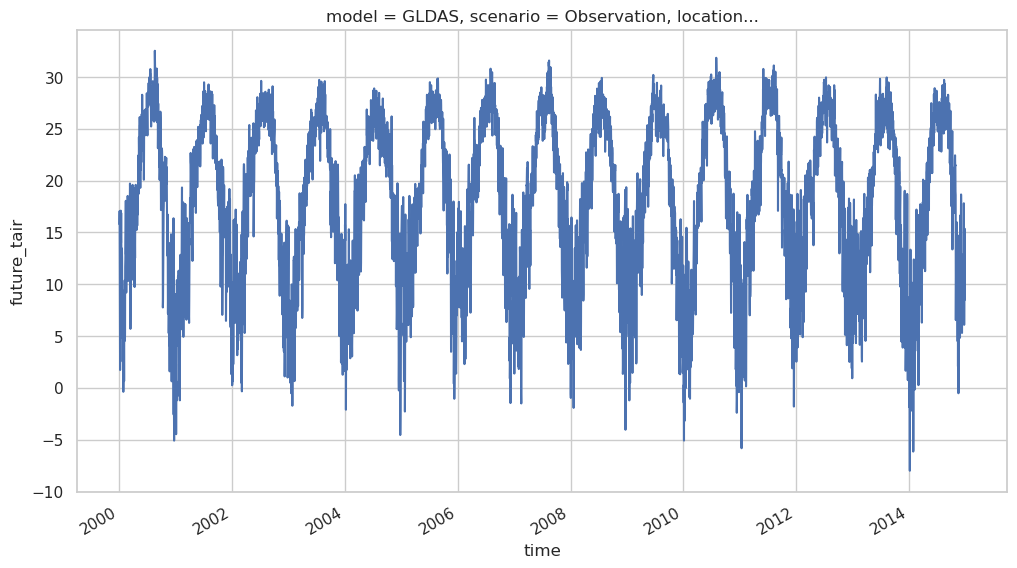

In [120]:
combined_ds.sel(scenario='Observation',model='GLDAS',location='desoto')['future_tair'].plot()

In [121]:
combo = combined_ds.to_dataframe().reset_index()

In [122]:
combo

,time,model,scenario,location,future_tair,psis,Ca,al,D
0,2000-01-01,CanESM5,Observation,desoto,NaN,NaN,NaN,NaN,NaN
1,2000-01-01,CanESM5,Observation,harvard,NaN,NaN,NaN,NaN,NaN
2,2000-01-01,CanESM5,Observation,sb,NaN,NaN,NaN,NaN,NaN
3,2000-01-01,CanESM5,ssp245,desoto,9.087613,-0.037650,420.0,10.0,171.611851
4,2000-01-01,CanESM5,ssp245,harvard,-2.730576,-0.099754,420.0,10.0,130.932008
...,...,...,...,...,...,...,...,...,...
197203,2014-12-30,NorESM2-MM,ssp245,harvard,NaN,NaN,NaN,NaN,NaN
197204,2014-12-30,NorESM2-MM,ssp245,sb,NaN,NaN,NaN,NaN,NaN
197205,2014-12-30,NorESM2-MM,ssp585,desoto,NaN,NaN,NaN,NaN,NaN
197206,2014-12-30,NorESM2-MM,ssp585,harvard,NaN,NaN,NaN,NaN,NaN


In [123]:
combo['time'] = pd.to_datetime(combo['time'])
combo = combo.groupby([combo['time'].dt.year,combo['model'],combo['scenario'],combo['location']]).mean('time')

In [124]:
combo

future_tair      psis     Ca    al  \
time model      scenario    location                                       
2000 CanESM5    Observation desoto            NaN       NaN    NaN   NaN   
                            harvard           NaN       NaN    NaN   NaN   
                            sb                NaN       NaN    NaN   NaN   
                ssp245      desoto      20.837426 -0.057646  420.0  10.0   
                            harvard     11.304903 -0.087928  420.0  10.0   
...                                           ...       ...    ...   ...   
2014 NorESM2-MM ssp245      harvard     10.742640 -0.105045  420.0  10.0   
                            sb          15.892884 -0.697742  420.0  10.0   
                ssp585      desoto      21.066191 -0.032606  420.0  10.0   
                            harvard     15.379382 -0.105045  420.0  10.0   
                            sb          19.434988 -0.697742  420.0  10.0   

                                               D  
time model      scenario    location              
2000 CanESM5    Observation desoto           NaN  
                            harvard          NaN  
                            sb               NaN  
                ssp245      desoto    614.816210  
                            harvard   243.314344  
...                                          ...  
2014 NorESM2-MM ssp245      harvard   281.635346  
                            sb        511.063474  
                ssp585      desoto    489.004031  
                            harvard   385.303877  
                            sb        630.753929  

[540 rows x 5 columns]

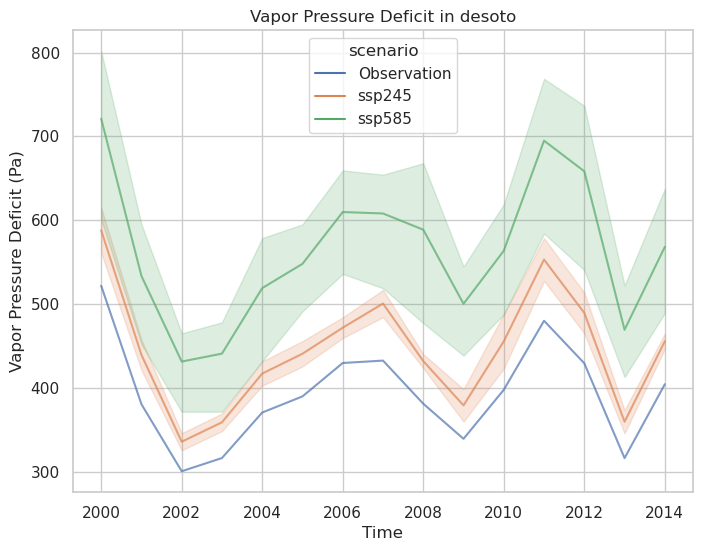

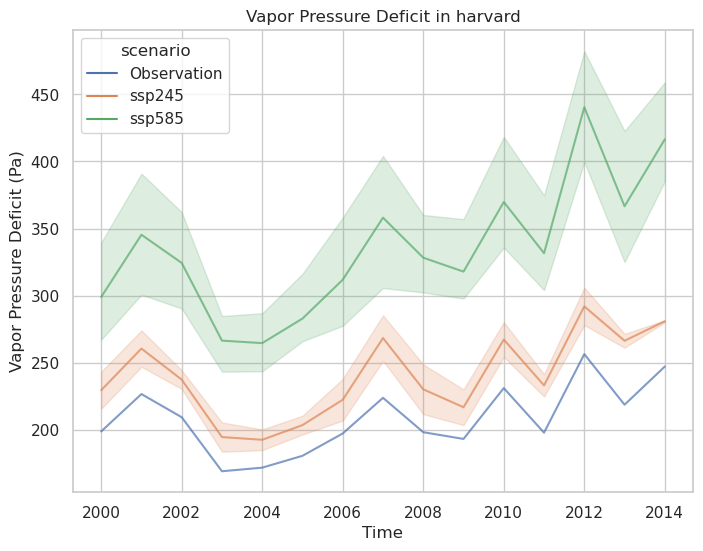

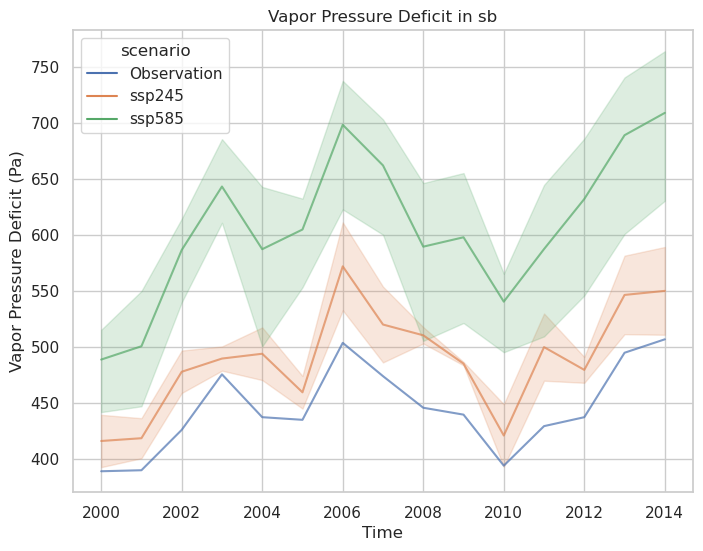

In [126]:
for location in combo.index.get_level_values('location').unique():
    filtered = combo[combo.index.get_level_values('location') == location]
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,6))
    p=sns.lineplot(data=filtered,x='time', y='D',hue='scenario',alpha=0.7)
    plt.title(f'Vapor Pressure Deficit in {location}')
    plt.xlabel('Time')
    plt.ylabel('Vapor Pressure Deficit (Pa)')
    plt.show()

## Working with HOTTER

In [127]:
# import hotter_loader
%run hotter_loader.py

location of the primary scripts for the HOTTER model and HOTTER demo
/home/mdshadman_amin/dev/Hotter/


location for HOTTER demo outputs
/home/mdshadman_amin/data/hotter_outputs/

    # Input Parameters (defaults)
    
    States
        Lx, Tree height, (m)
        dbh, Tree diameter at breast height, (cm)
        al, Leaf area, (m2)
    Drivers
        Ca, Atmospheric CO2 concentration, (ppm), mean 1976-2005, 352.84 historical    
        D, Atmospheric vapor pressure deficit, (Pa)    
        Tair, Air temperature, (°C)
        psis, Soil water potential, (MPa)
    
    Key Parameters
        Kmax, Saturated xylem water conductivity, (mmol H2O m-1 s-1 MPa-1)
        b1, Logistic curve slope, (MPa)
        b2, P50 equivalent, (MPa)
        Vcmax0, Optimal Maximum rate of carboxylation at 25C, (umol m-2 s-1), coordinated with Jmax
        SLA, Specific leaf area, (m2 leaf per kgC)
        rG, Tree growth respiration, (fraction)
        q, Ratio of fine roots to leaves, (fraction)
    

<Figure size 1200x600 with 0 Axes>

In [128]:
# Create an input dictionary for HOTTER with default values
import pprint

input_dictionary_main = helper_scripts.default_hotter_input_dict()

pprint.pprint(input_dictionary_main)

{'Kmax': 40000,
 'LR': 18000.0,
 'Lp': 0.1,
 'SLA': 32,
 'SRA': 80,
 'Vcmax0': 80,
 'b1': 2,
 'b2': -2,
 'dbh2h1': 3.6,
 'q': 1.89,
 'rG': 0.3,
 'rho': 420,
 'sap_frac': 0.622}


In [129]:
directory = '/home/mdshadman_amin/dev/CMIP/mets/hotter_load/'
dfs = []
for filename in os.listdir(directory):
    if filename.endswith('.csv') and filename.startswith('hotter_'):
        # Extract the model, scenario, and location from the filename
        parts = filename.split('_')
        model = parts[1]
        scenario = parts[2]
        location = parts[3]

        # Load the CSV file
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)

        # Debugging: Check the first few rows and columns
        print(f"Loaded {filename} with columns: {df.columns}")
        if 'ssp245' in filename or 'ssp585' in filename:
            print(f"Dropping 'model' and 'scenario' columns from {filename}")
            df = df.drop(columns=['model', 'scenario'])
        if 'tair' in df.columns:
            print(f"Renaming 'tair' to 'future_tair' in {filename}")
            df = df.rename(columns={'tair': 'future_tair'})

        # Add model, scenario, and location as new columns to the dataframe
        df['model'] = model
        df['scenario'] = scenario
        df['location'] = location

        # Append the dataframe to the list
        dfs.append(df)

# Concatenate all dataframes into a single one
combined_df = pd.concat(dfs)
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Debugging: Check the combined DataFrame
print("Combined DataFrame preview:")
print(combined_df.head())


Loaded hotter_NorESM2-MM_ssp245_harvard_met.csv with columns: Index(['model', 'scenario', 'time', 'future_tair', 'psis', 'Ca', 'al', 'D'], dtype='object')
Dropping 'model' and 'scenario' columns from hotter_NorESM2-MM_ssp245_harvard_met.csv
Loaded hotter_CanESM5_ssp245_desoto_met.csv with columns: Index(['model', 'scenario', 'time', 'future_tair', 'psis', 'Ca', 'al', 'D'], dtype='object')
Dropping 'model' and 'scenario' columns from hotter_CanESM5_ssp245_desoto_met.csv
Loaded hotter_NorESM2-MM_ssp585_desoto_met.csv with columns: Index(['model', 'scenario', 'time', 'future_tair', 'psis', 'Ca', 'al', 'D'], dtype='object')
Dropping 'model' and 'scenario' columns from hotter_NorESM2-MM_ssp585_desoto_met.csv
Loaded hotter_CanESM5_ssp245_harvard_met.csv with columns: Index(['model', 'scenario', 'time', 'future_tair', 'psis', 'Ca', 'al', 'D'], dtype='object')
Dropping 'model' and 'scenario' columns from hotter_CanESM5_ssp245_harvard_met.csv
Loaded hotter_NorESM2-MM_ssp585_sb_met.csv with colu

In [ ]:
#Testing how the looping works to push it all in HOTTER

# for model in combined_df['model'].unique():
#     for location in combined_df['location'].unique():
#         for scenario in combined_df['scenario'].unique():
#             if model == 'GLDAS' and scenario != 'Observation':
#                 continue  # Skip non-'Observation' scenarios for 'GLDAS'
#             elif model != 'GLDAS' and scenario == 'Observation':
#                 continue  # Skip 'Observation' scenario for models other than 'GLDAS'
#             filtered = combined_df[
#                 (combined_df['model'] == model) &
#                 (combined_df['location'] == location) &
#                 (combined_df['scenario'] == scenario)
#             ]
#             if model == 'GLDAS':
#                 filtered['D'] *= 100

In [130]:
outputlist = ['NPP', 'K_frac']
options_dict = input_dictionary_main.copy()
output_combined_dict = {}
Lx = 5         # Tree height (m)
dbh = None      # Tree diameter at breast height (cm)
for model in combined_df['model'].unique():
    for location in combined_df['location'].unique():
        for scenario in combined_df['scenario'].unique():
            if model == 'GLDAS' and scenario != 'Observation':
                continue  # Skip non-'Observation' scenarios for 'GLDAS'
            elif model != 'GLDAS' and scenario == 'Observation':
                continue  # Skip 'Observation' scenario for models other than 'GLDAS'
            filtered = combined_df[
                (combined_df['model'] == model) &
                (combined_df['location'] == location) &
                (combined_df['scenario'] == scenario)
            ]
            if model == 'GLDAS':
                filtered['D'] *= 100
            
            # Extract the meteorological data for this combination
            df_met = filtered.copy()
            
            # Run the HOTTER model for the time vector of meteorology input
            output_dict_time = hotter_optimization.hotter_flux_time(df_met['future_tair'], df_met['psis'], df_met['D'], df_met['Ca'], df_met['al'],
                          dbh, Lx, outputlist, **options_dict)
            for var in outputlist:
                output_dict_time[var] = output_dict_time[var].squeeze()
            # Convert the output_dict_time into a DataFrame and add time and meteorological variables
            df_output = pd.DataFrame.from_dict(output_dict_time)
            df_output['time'] = df_met['time']
            df_output['Tair'] = df_met['future_tair']
            df_output['D'] = df_met['D']
            df_output['PLC'] = 1 - df_output['K_frac']

            # Store the result in the combined dictionary with the model-scenario-location combination as the key
            output_combined_dict[(model, scenario, location)] = df_output

            # Optionally, save the output to a CSV file
            fname_output_here = f'hotter_{model}_{scenario}_{location}_output.csv'
            df_output.to_csv(output_directory + fname_output_here)

            # Print out the results for debugging
            pprint.pprint(df_output)

# Optionally, to consolidate the outputs, you can merge them into a single DataFrame or xarray:
# Example: Merge all DataFrames into one for easier plotting
combined_output_df = pd.concat(output_combined_dict.values(), keys=output_combined_dict.keys(), names=['model', 'scenario', 'location'])

       K_frac        NPP       time       Tair           D       PLC
0    0.939647  13.320992 2000-01-01  -4.432581  115.236218  0.060353
1    0.913640  20.230203 2000-02-01  -0.051060  122.037444  0.086360
2    0.827471  30.390322 2000-03-01   6.443847  163.296782  0.172529
3    0.790290  32.460401 2000-04-01   9.609727  179.965058  0.209710
4    0.755781  30.778259 2000-05-01  15.250358  199.966082  0.244219
..        ...        ...        ...        ...         ...       ...
175  0.699518   3.485870 2014-08-01  22.422118  530.565433  0.300482
176  0.705855   8.429674 2014-09-01  19.275363  460.528584  0.294145
177  0.737235  24.744323 2014-10-01  14.979133  246.872126  0.262765
178  0.778927  25.639287 2014-11-01   6.420948  235.927599  0.221073
179  0.868518  31.091400 2014-12-01   5.470095  117.873097  0.131482

[180 rows x 6 columns]
       K_frac        NPP       time       Tair           D       PLC
0    0.840316  23.704829 2000-01-01   2.916512  197.431761  0.159684
1    0.826

In [111]:
final_ds = xr.Dataset.from_dataframe(combined_output_df)

## Visualize again

In [131]:
combined_output_df

K_frac        NPP       time  \
model      scenario    location                                        
NorESM2-MM ssp245      harvard  0     0.939647  13.320992 2000-01-01   
                                1     0.913640  20.230203 2000-02-01   
                                2     0.827471  30.390322 2000-03-01   
                                3     0.790290  32.460401 2000-04-01   
                                4     0.755781  30.778259 2000-05-01   
...                                        ...        ...        ...   
GLDAS      Observation sb       5473  0.583636   7.801513 2014-12-26   
                                5474  0.603514  13.900257 2014-12-27   
                                5475  0.572185   5.382895 2014-12-28   
                                5476  0.608178  16.130647 2014-12-29   
                                5477  0.633132  23.270306 2014-12-30   

                                           Tair           D       PLC  
model      scenario    location                                        
NorESM2-MM ssp245      harvard  0     -4.432581  115.236218  0.060353  
                                1     -0.051060  122.037444  0.086360  
                                2      6.443847  163.296782  0.172529  
                                3      9.609727  179.965058  0.209710  
                                4     15.250358  199.966082  0.244219  
...                                         ...         ...       ...  
GLDAS      Observation sb       5473   9.522980  414.388850  0.416364  
                                5474   8.778473  279.881950  0.396486  
                                5475   9.845062  498.052700  0.427815  
                                5476  11.065674  236.348440  0.391822  
                                5477   9.784668  167.327310  0.366868  

[19674 rows x 6 columns]

In [132]:
pre_combo = combined_output_df.copy()

In [138]:
df=pre_combo.reset_index()
df['model']= df['model'].astype('category')
df['scenario']= df['scenario'].astype('category')
df['location']= df['location'].astype('category')

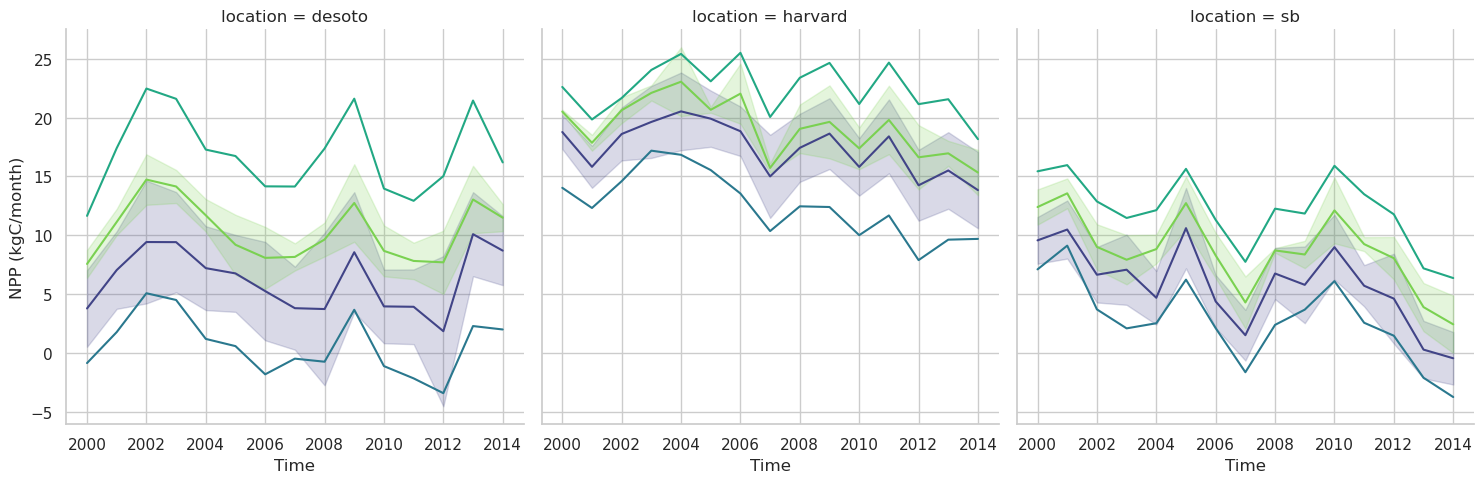

In [148]:
sns.set_theme(style="whitegrid")
g= sns.FacetGrid(df, col='location', hue='model', palette='viridis', height=5)
g.map(sns.lineplot,'time','NPP')
g.set_ylabels('NPP (kgC/month)')
g.set_xlabels('Time')
plt.show()

In [135]:
pre_combo['time'] = pd.to_datetime(pre_combo['time'])
pre_combo = pre_combo.groupby([pre_combo['time'].dt.year,'model','scenario','location']).mean('time')

In [136]:
df = pre_combo.copy()

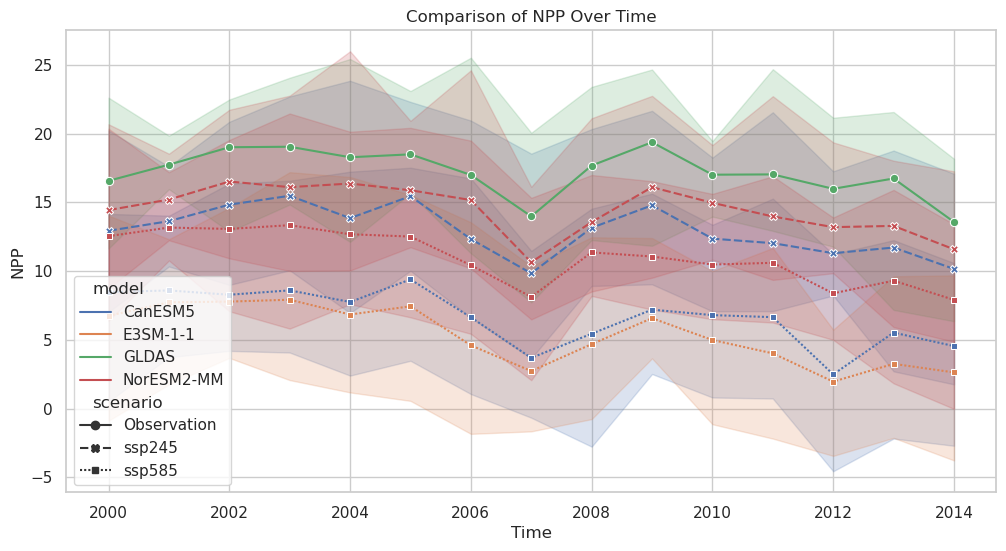

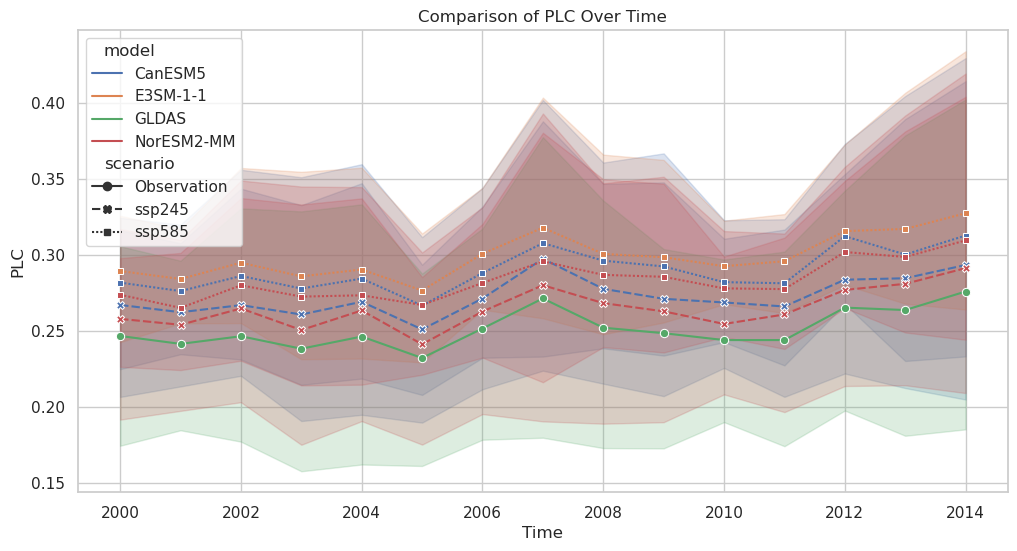

In [143]:
sns.lineplot(data=df, x='time', y='NPP', hue='model', style='scenario', markers=True)
plt.title("Comparison of NPP Over Time")
plt.xlabel("Time")
plt.ylabel("NPP")
plt.show()

# Line plot for PLC comparison over time
sns.lineplot(data=df, x='time', y='PLC', hue='model', style='scenario', markers=True)
plt.title("Comparison of PLC Over Time")
plt.xlabel("Time")
plt.ylabel("PLC")
plt.show()


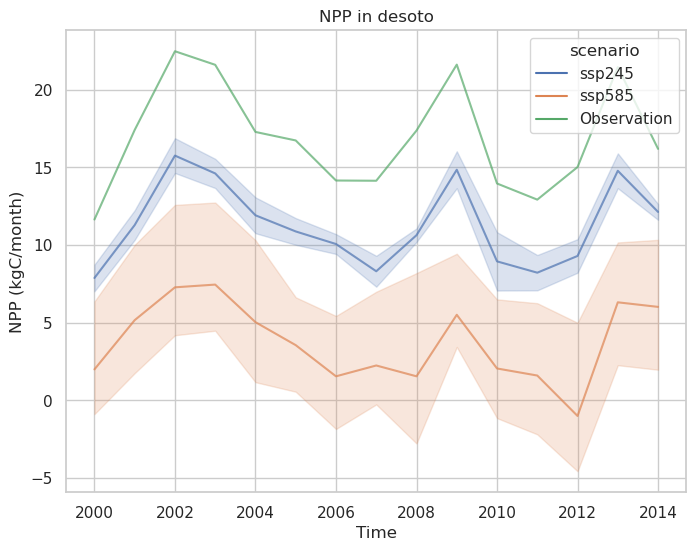

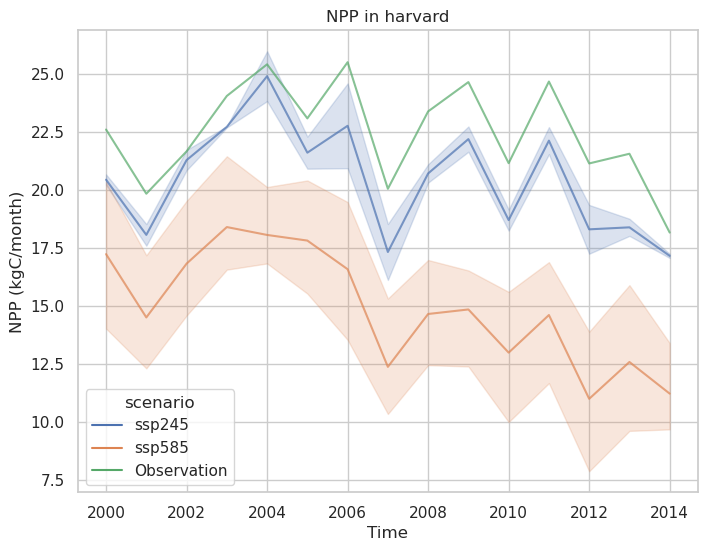

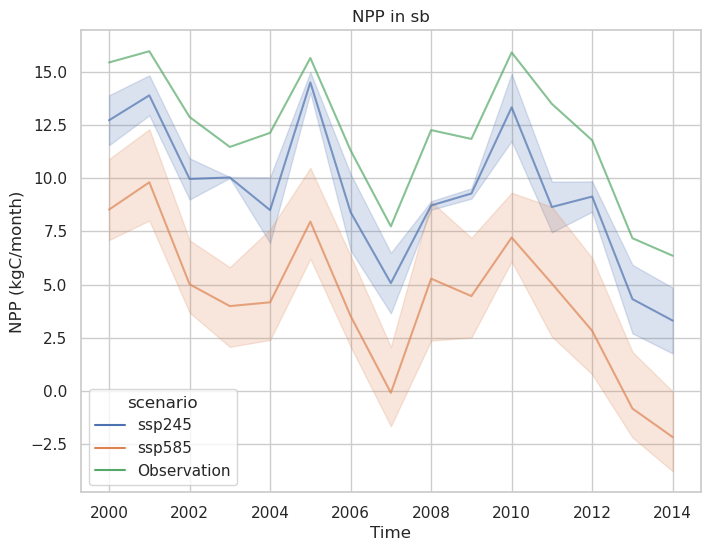

In [144]:
for location in pre_combo.index.get_level_values('location').unique():
    filtered = pre_combo[pre_combo.index.get_level_values('location') == location]
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,6))
    p=sns.lineplot(data=filtered,x='time', y='NPP',hue='scenario',alpha=0.7)
    plt.title(f'NPP in {location}')
    plt.xlabel('Time')
    plt.ylabel('NPP (kgC/month)')
    plt.show()

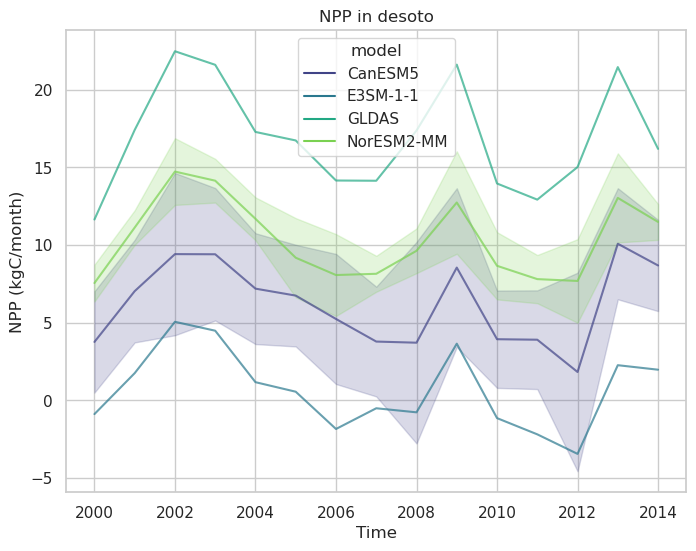

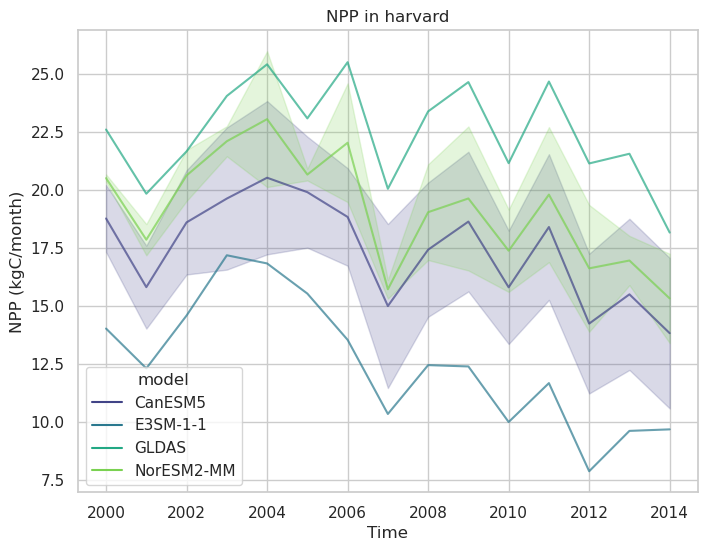

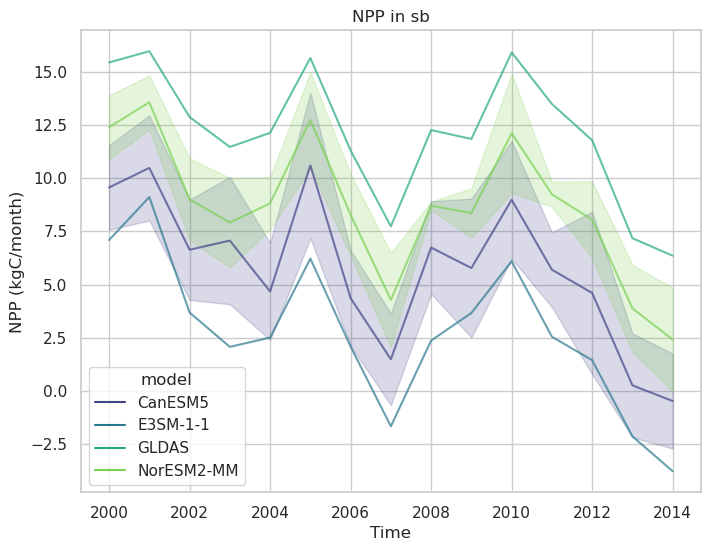

In [145]:
for location in pre_combo.index.get_level_values('location').unique():
    filtered = pre_combo[pre_combo.index.get_level_values('location') == location]
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,6))
    p=sns.lineplot(data=filtered,x='time', y='NPP',hue='model',alpha=0.7, palette='viridis')
    plt.title(f'NPP in {location}')
    plt.xlabel('Time')
    plt.ylabel('NPP (kgC/month)')
    plt.show()

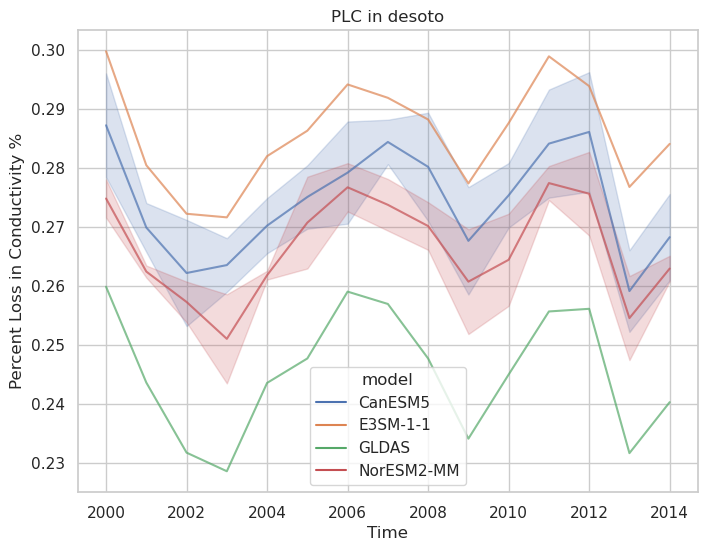

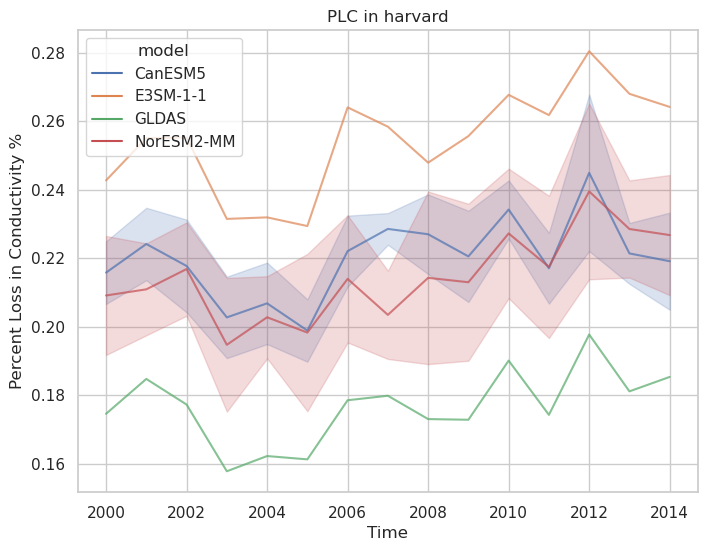

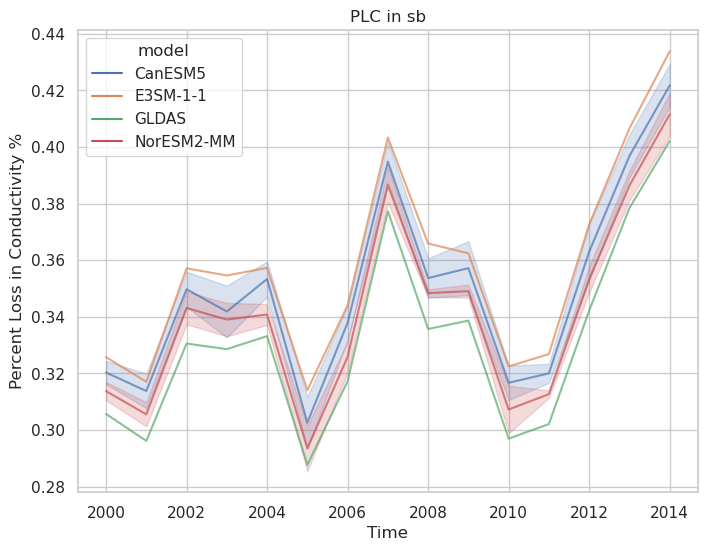

In [150]:
for location in pre_combo.index.get_level_values('location').unique():
    filtered = pre_combo[pre_combo.index.get_level_values('location') == location]
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,6))
    p=sns.lineplot(data=filtered,x='time', y='PLC',hue='model',alpha=0.7)
    plt.title(f'PLC in {location}')
    plt.xlabel('Time')
    plt.ylabel('Percent Loss in Conductivity %')
    plt.show()